In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics # for the evaluation
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import math
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense

###### predict date range ######
# pd.date_range(start="2021-12-26",end="2022-01-01")
# pd.date_range(start="2022-01-23",end="2022-01-29")

In [9]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
  X = []
  y = []
  start = start + window
  if end is None:
    end = len(dataset) - horizon
  for i in range(start, end):
    indices = range(i-window, i)
    X.append(dataset[indices])
    indicey = range(i+1, i+1+horizon)
    y.append(target[indicey])
  return np.array(X), np.array(y) 

In [50]:
df0 = pd.read_csv('smart_farm_train_nonull.csv')

test_idx = df0[df0['년월일'] < '2022-02-01'].shape[0]

df0['열공급량(kWh)'] = df0['열공급량(kWh)'] * 1000
df0.set_index('시간',inplace=True)
df0.drop(columns=['년월일', '년도', '월', '시', '분'],inplace=True)
df0.head()

,일,일사량(W/㎡),외기온(℃),외기습도(%),풍속(m/s),풍향(º),내부 온도,내부 습도,차광스크린(수평),차열스크린(수평),에너지스크린(수평),에너지스크린(수직),배기팬,천창,유동팬,팬코일 B동,환기온도(천창 제어온도),난방온도(설정온도),열공급량(kWh)
시간,,,,,,,,,,,,,,,,,,,
2021-11-26 00:00:00,26,-2.7,5.8,67,0.0,325,18.3,62.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,900.0
2021-11-26 00:01:00,26,-2.9,5.8,67,0.4,344,18.1,63.4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,28.0,18.0,900.0
2021-11-26 00:02:00,26,-3.0,5.7,67,0.9,105,17.7,65.2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,900.0
2021-11-26 00:03:00,26,-3.0,5.7,67,1.3,123,17.7,63.9,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,800.0
2021-11-26 00:04:00,26,-2.8,5.7,67,0.9,123,17.6,64.7,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,28.0,18.0,1000.0


In [51]:
X_scaler = StandardScaler()
Y_scaler = StandardScaler()
X_data = X_scaler.fit_transform(df0[df0.columns.difference(['열공급량(kWh)'])]) 
Y_data = Y_scaler.fit_transform(df0[['열공급량(kWh)']])

In [52]:
# As we are doing multiple-step forecasting, let’s allow the model to see past 48 hours of data and forecast the 10 hrs after data
# hist_window = 48 / horizon = 10

# row : min -> 분단위 예측~
hist_window = 60
horizon = 10
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, test_idx, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, test_idx, None, hist_window, horizon) 


In [53]:
batch_size = 64
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat()

In [54]:
lstm_model = tf.keras.models.Sequential([
    Bidirectional(LSTM(100, return_sequences=True), input_shape=x_train.shape[-2:]),
    Dense(128, activation='tanh'),
    Bidirectional(tf.keras.layers.LSTM(100)),
    tf.keras.layers.Dropout(0.4),
    Dense(128, activation='tanh'),
    Dense(64, activation='tanh'),
    tf.keras.layers.Dropout(0.4),
    Dense(units=horizon),
])
lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.007), loss=tf.keras.metrics.mean_squared_error, metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')])
lstm_model.summary() 

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_10 (Bidirecti  (None, 60, 200)          95200     
 onal)                                                           
                                                                 
 dense_20 (Dense)            (None, 60, 128)           25728     
                                                                 
 bidirectional_11 (Bidirecti  (None, 200)              183200    
 onal)                                                           
                                                                 
 dropout_10 (Dropout)        (None, 200)               0         
                                                                 
 dense_21 (Dense)            (None, 128)               25728     
                                                                 
 dense_22 (Dense)            (None, 64)               

In [55]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]
history = lstm_model.fit(train_data,epochs=100,steps_per_epoch=100,validation_data=val_data,validation_steps=20,verbose=1,callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - 12s 95ms/step - loss: 1.3734 - rmse: 1.1719 - val_loss: 1.3091 - val_rmse: 1.1442
Epoch 2/100
100/100 [==============================] - 8s 84ms/step - loss: 1.6395 - rmse: 1.2804 - val_loss: 0.6936 - val_rmse: 0.8329
Epoch 3/100
100/100 [==============================] - 8s 84ms/step - loss: 1.3148 - rmse: 1.1466 - val_loss: 0.9975 - val_rmse: 0.9988
Epoch 4/100
100/100 [==============================] - 8s 84ms/step - loss: 0.7539 - rmse: 0.8683 - val_loss: 0.8238 - val_rmse: 0.9076
Epoch 5/100
100/100 [==============================] - 9s 85ms/step - loss: 1.1093 - rmse: 1.0532 - val_loss: 0.9160 - val_rmse: 0.9571
Epoch 6/100
100/100 [==============================] - 8s 84ms/step - loss: 1.0838 - rmse: 1.0411 - val_loss: 0.7809 - val_rmse: 0.8837
Epoch 7/100
100/100 [==============================] - 8s 84ms/step - loss: 1.2738 - rmse: 1.1286 - val_loss: 0.7957 - val_rmse: 0.8920
Epoch 8/100
100/100 [==========================

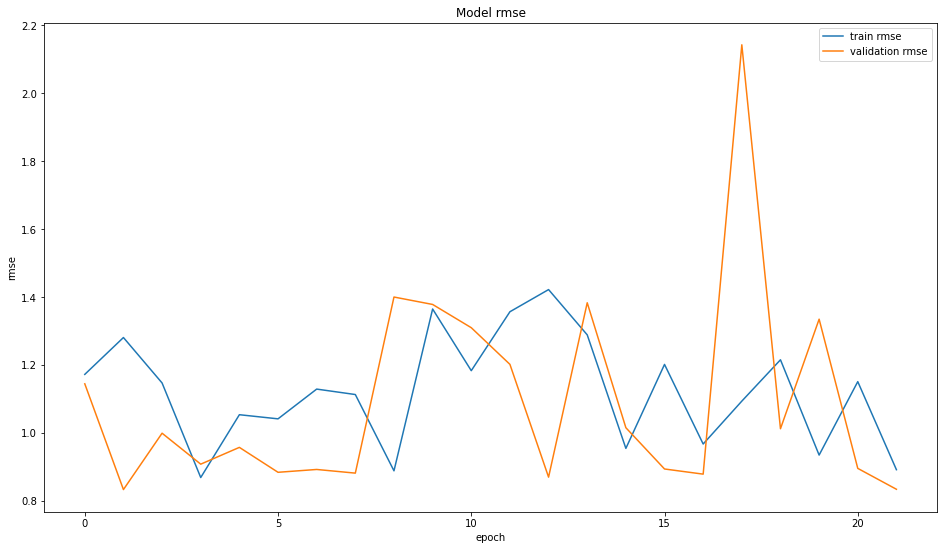

In [56]:
plt.figure(figsize=(16,9))
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('Model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train rmse', 'validation rmse'])
plt.show()

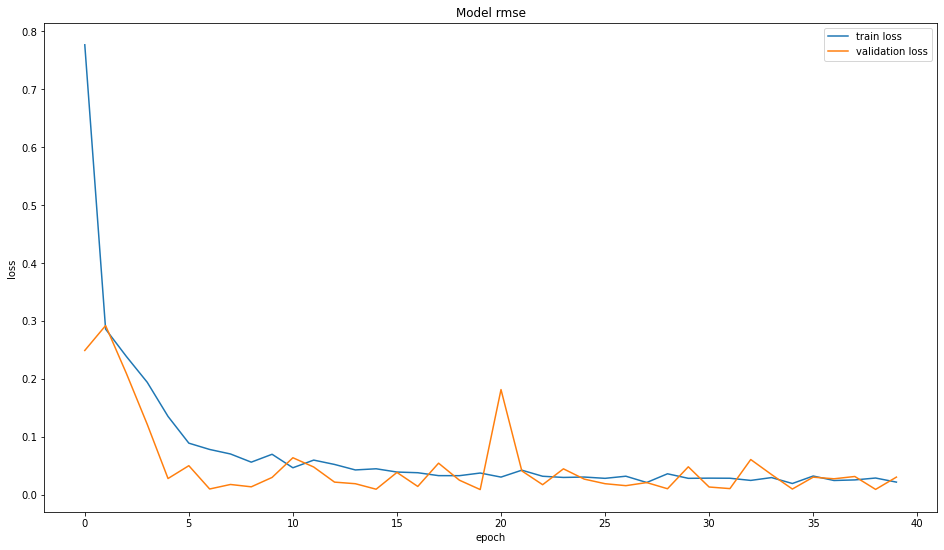

In [33]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model rmse')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show()